# Setup

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
import os 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
lsa_reports = "../../../reports/lsa/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

In [4]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

# Cargo archivos

In [65]:
#Analisis previos
infomap_clusters = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [5]:
# Document-Term-Matrix  de clusters

path_infomap = data_processed + "tfidf_infomap/"
path_louvain = data_processed + "tfidf_louvain/"

monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [6]:
# Document-Term-Matrix de nodos
path = data_processed + "tfidf_nodos/"
monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

# Scree plot

### Nodos

In [6]:
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=1400)
lsa = svd.fit(X_nodos)

In [ ]:
y = lsa.explained_variance_ratio_
x = np.linspace(1,len(y),len(y))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,"o-")

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=2000)
ax.set_ylabel('Fracción de varianza acumulada - Nodos')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 80% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")

### Clusters

In [ ]:
X_infomap = infomap_dtm[0].sparse.to_dense()

svd_infomap = TruncatedSVD(n_components=1000)
lsa_infomap = svd_infomap.fit(X_infomap)

X_louvain = louvain_dtm[0].sparse.to_dense()

svd_louvain = TruncatedSVD(n_components=1000)
lsa_louvain = svd_louvain.fit(X_louvain)

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_infomap.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Infomap')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")


# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_louvain.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Louvain')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")

In [ ]:
corte_infomap = 477
corte_louvain = 154

# Armo el modelo

### Clusters

In [ ]:
svd_infomap = TruncatedSVD(n_components=corte_infomap)
lsa_infomap = svd_infomap.fit(X_infomap)
lsa_infomap_data = lsa_infomap.transform(X_infomap)

svd_louvain = TruncatedSVD(n_components=corte_louvain)
lsa_louvain = svd_louvain.fit(X_louvain)
lsa_louvain_data = lsa_louvain.transform(X_louvain)

In [ ]:
# most important words for each topic
vocab_louvain = X_louvain.columns.values
component_data = {}

for i, comp in enumerate(lsa_louvain.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_louvain, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_louvain = pd.DataFrame.from_dict(component_data,orient="index")

In [ ]:
# most important words for each topic
vocab_infomap = X_infomap.columns.values
component_data = {}

for i, comp in enumerate(lsa_infomap.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_infomap, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_infomap = pd.DataFrame.from_dict(component_data,orient="index")

### Nodos

In [6]:
# component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
# lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [7]:
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=250)
lsa_data = svd.fit_transform(X_nodos)

# lsa_data = lsa.transform(X_nodos)

In [8]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(svd.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

Guardo matrices para no tener que volver a calcularlas

In [14]:
# component_vocab.to_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [9]:
sorted(zip(vocab,svd.components_[5]), key= lambda x:x[1], reverse=True)[:10]

[('spastic', 0.21968518485374108),
 ('hmsn', 0.21523628305065348),
 ('paraplegia', 0.19217455039155895),
 ('neuropathy', 0.1845861855400983),
 ('sensory', 0.17380942405655922),
 ('nerve', 0.1586147681175036),
 ('hereditary', 0.15518742096760796),
 ('motor', 0.1488971846048407),
 ('charcot', 0.13594199334505586),
 ('marie', 0.1357628612695355)]

In [10]:
component_vocab

,wordlist,scorelist
0,"[autosomal, recessive, cell, muscle, rare, inc...","[0.254, 0.186, 0.151, 0.139, 0.135, 0.134, 0.1..."
1,"[autosomal, recessive, deafness, retardation, ...","[0.333, 0.249, 0.235, 0.16, 0.153, 0.153, 0.12..."
2,"[deafness, autosomal, neoplasm, recessive, car...","[0.312, 0.298, 0.234, 0.225, 0.219, 0.21, 0.18..."
3,"[dystrophy, retinitis, pigmentosa, deafness, r...","[0.359, 0.274, 0.27, 0.215, 0.185, 0.15, 0.149..."
4,"[retardation, mental, dystrophy, link, intelle...","[0.325, 0.308, 0.244, 0.229, 0.2, 0.188, 0.153..."
...,...,...
245,"[dysostosis, spondylocostal, myeloid, mole, ve...","[0.161, 0.14, 0.088, 0.084, 0.083, 0.082, 0.08..."
246,"[hemangioma, dysostosis, alzheimer, polymicrog...","[0.149, 0.137, 0.126, 0.12, 0.107, 0.102, 0.1,..."
247,"[affective, dysostosis, nevus, major, myotonia...","[0.116, 0.11, 0.104, 0.104, 0.097, 0.096, 0.09..."
248,"[epithelial, paralysis, diarrhea, vitreoretino...","[0.113, 0.111, 0.108, 0.106, 0.104, 0.098, 0.0..."


### Obtengo la matriz de similaridad

In [ ]:
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [11]:
# Esta linea solo si cargué los datos como matriz sparse
# lsa_data_dense = lsa_data.toarray()


lsa_similarity_matrix = cosine_similarity(lsa_data,lsa_data)

Convierto a sparse y guardo

In [19]:
# lsa_similarity_matrix_sparse = sparse.csr_matrix(lsa_similarity_matrix)
# sparse.save_npz(lsa_reports+"lsa_similarity_matrix.npz",lsa_similarity_matrix_sparse)

## Checkpoint

In [5]:
component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [12]:
from wordcloud import WordCloud

def plot_component_vocab(component,component_vocab):
    n = component
    fig,ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=component_vocab.loc[n,"wordlist"], y=component_vocab.loc[n,"scorelist"], ax=ax)
    ax.set_title(f"Top 10 términos de la componente {n}")
    plt.xticks(rotation=45)
    plt.tight_layout()

def wordcloud_component_vocab(component,component_vocab):
    n = component
    words = component_vocab.loc[n,"wordlist"]
    scores = component_vocab.loc[n,"scorelist"]
    wordcloud_dict = {word:score for (word,score) in zip(words,scores)}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

In [ ]:
wordcloud_component_vocab(8,component_vocab_louvain)

In [ ]:
plot_component_vocab(8,component_vocab_louvain)

In [ ]:
lsa_infomap_df = pd.DataFrame(lsa_infomap_data, index=X_infomap.index.values)
lsa_louvain_df = pd.DataFrame(lsa_louvain_data, index=X_louvain.index.values)

In [ ]:
random_cluster = np.random.choice(X_infomap.index.values,1)[0]
top_component = lsa_infomap_df.loc[random_cluster].idxmax()

plot_component_vocab(top_component,component_vocab_infomap)
wordcloud_component_vocab(top_component,component_vocab_infomap)
disease_attributes[disease_attributes.comunidades_infomap == random_cluster]

array(['ALK positive large B-cell lymphoma',
       'Anaplastic lymphoma kinase (ALK)-positive diffuse large B-cell lymphoma is a very rare variant of diffuse large B-cell lymphoma (DLBCL) mainly affecting middle-aged immunocompetent men and characterized by a consistent primary involvement of lymph nodes (mainly in the cervical and mediastinum lymph nodes) and with infrequent extra nodal involvement of the bone marrow and other extra-nodal sites (head and neck region, liver, spleen, and gastrointestinal tract). It has an aggressive disease course, and is associated with a poor prognosis.',
       'A usually aggressive large B-cell lymphoma characterized by the presence of monomorphic immunoblast-like neoplastic B-lymphocytes in a sinusoidal growth pattern. The neoplastic B-lymphocytes express the ALK kinase but they lack the 2;5 translocation.',
       'A very rare variant of diffuse large B-cell lymphoma (DLBCL) mainly affecting middle-aged immunocompetent men and characterized by a 

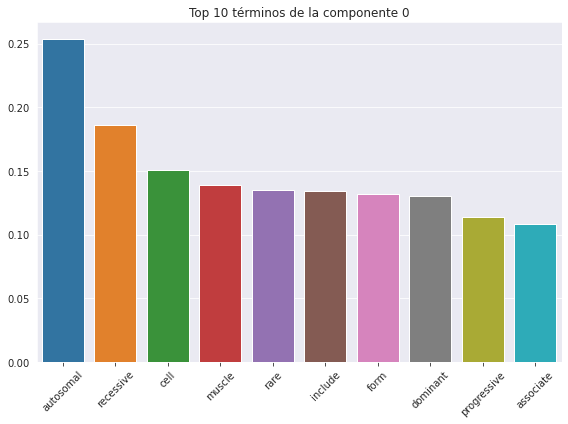

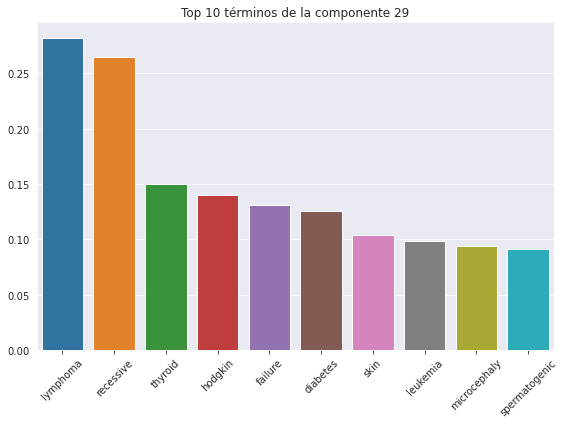

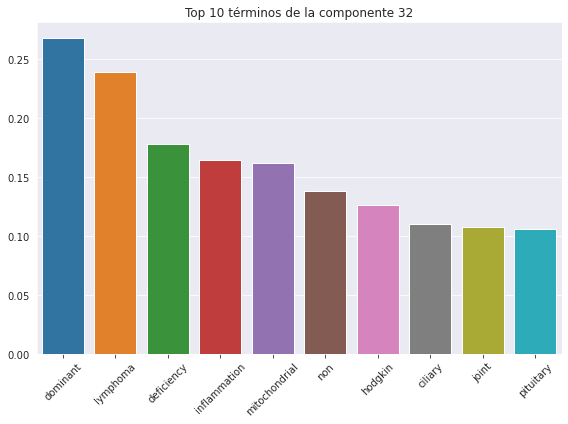

In [61]:
nodo = np.random.choice(range(lsa_data.shape[0]),1)[0]
vector_lsa = lsa_data[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:3]:
    plot_component_vocab(component, component_vocab)

# Vuelvo a ver similaridad

In [62]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(np.mean(cluster_matrix.values), 2)

def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)
    
def get_similarity(document_term_matrix,df=True):
    ids = document_term_matrix.index.values
    scores = sparse.csr_matrix(document_term_matrix.values)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

In [69]:
ids = disease_attributes.node_index.values
# lsa_similarity_matrix_df = pd.DataFrame.sparse.from_spmatrix(lsa_similarity_matrix, index=ids, columns=ids)
lsa_similarity_matrix_df = pd.DataFrame(lsa_similarity_matrix,index=ids, columns=ids)

In [71]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(lsa_similarity_matrix_df, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="mean_similarity_lsa")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(lsa_similarity_matrix_df, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="mean_similarity_lsa")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

Text(0.5, 1.0, 'Louvain')

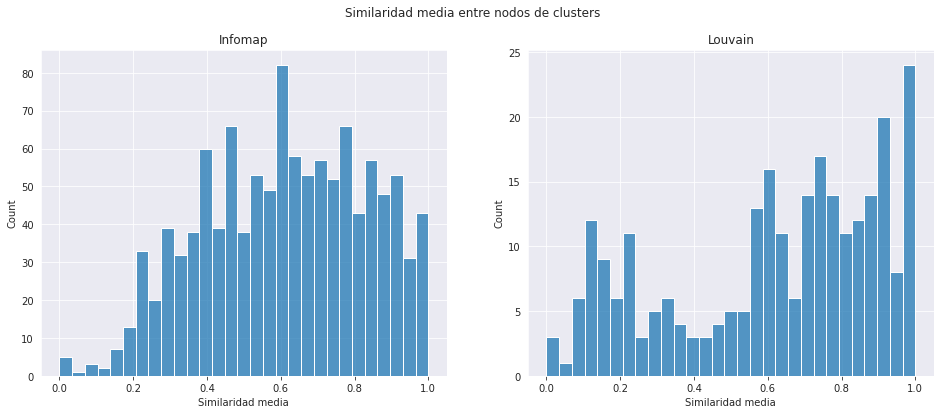

In [72]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Similaridad media entre nodos de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=infomap_clusters,x="mean_similarity_lsa", ax=ax[0], bins=np.linspace(0,1,30))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="mean_similarity_lsa", ax=ax[1], bins=np.linspace(0,1,30))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

In [75]:
aver = infomap_clusters[["comunidad","tamaño","mean_similarity_mono","mean_similarity_lsa"]]
aver[aver.mean_similarity_mono < aver.mean_similarity_lsa]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_lsa
0,3,198,0.09,0.23
1,354,82,0.64,0.87
2,188,74,0.57,0.68
3,416,74,0.83,0.91
4,436,71,0.74,0.91
...,...,...,...,...
1121,1061,2,0.56,0.57
1122,1138,2,0.83,0.88
1125,1002,2,0.82,0.89
1129,1092,2,0.64,0.69


In [77]:
# similaridad_todos = lsa_similarity_matrix.toarray()
similaridad_todos_indices = np.triu_indices_from(lsa_similarity_matrix,1)
similaridad_todos_values = lsa_similarity_matrix[similaridad_todos_indices]

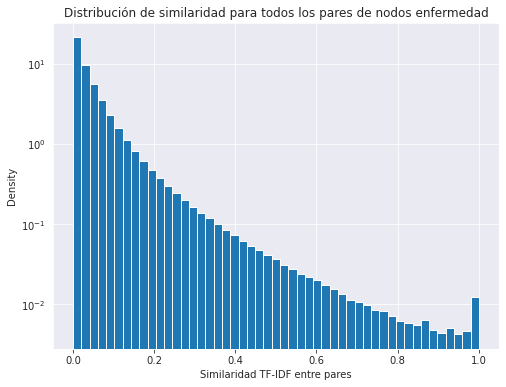

In [78]:
plt.figure(figsize=(8,6))
plot = plt.hist(similaridad_todos_values,bins=np.linspace(0,1,50),log=True, density=True)
plt.title("Distribución de similaridad para todos los pares de nodos enfermedad")
plt.xlabel("Similaridad TF-IDF entre pares")
plt.ylabel("Density")
plt.savefig(lsa_reports+"similaridad_todos.png",dpi=200)

# PCA

In [97]:
X_nodos = monograms_dtm.sparse.to_dense()

pca = PCA(n_components=250)
pca_data = pca.fit_transform(X_nodos)

In [98]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(pca.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

pca_component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

In [104]:
sorted(zip(vocab,pca.components_[1]), key= lambda x:x[1], reverse=True)[:10]

[('deafness', 0.30677767565576297),
 ('autosomal', 0.30130530885676904),
 ('neoplasm', 0.2600947884316583),
 ('carcinoma', 0.24086478533653283),
 ('malignant', 0.2336764269942495),
 ('recessive', 0.22779520194464464),
 ('cell', 0.21607471234675982),
 ('nonsyndromic', 0.16308196169723568),
 ('tumor', 0.14614727626153173),
 ('sensorineural', 0.13978353941520266)]

array(['Stromal tumor of ovary',
       'A benign or malignant neoplasm that arises from the ovary and is composed of granulosa cells, Sertoli cells, Leydig cells, theca cells, and fibroblasts. Representative examples include thecoma, fibroma, Sertoli cell tumor, and granulosa cell tumor.',
       'A benign or malignant neoplasm that arises from the ovary and is composed of granulosa cells, Sertoli cells, Leydig cells, theca cells, and fibroblasts. ',
       nan], dtype=object)

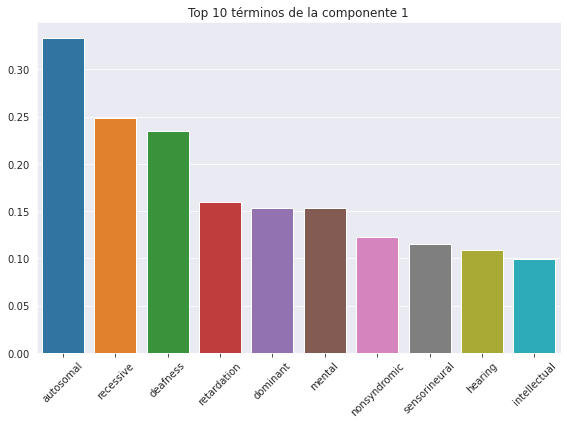

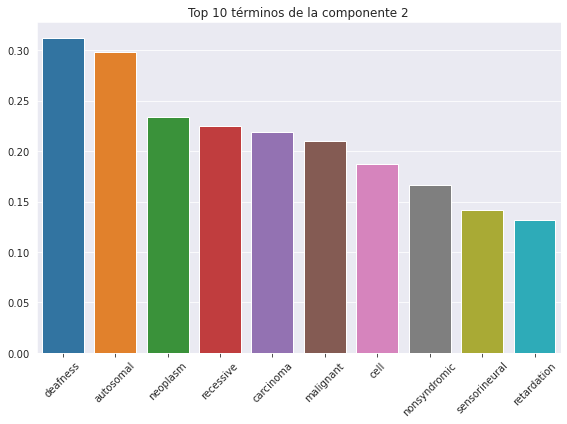

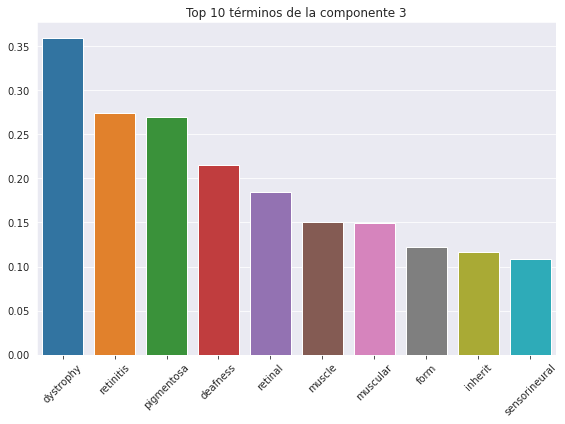

In [114]:
nodo = np.random.choice(range(pca_data.shape[0]),1)[0]
vector_pca = pca_data[nodo]
top_10_components_idx = np.argsort(-vector_pca)[0:10]
top_10_components_score = vector_pca[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:3]:
    plot_component_vocab(component, component_vocab)